## Provable Linear Regression Solver

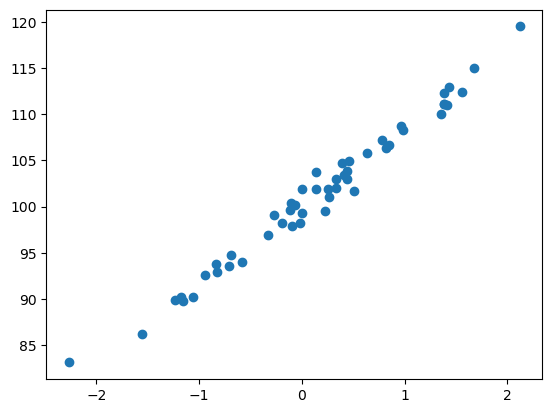

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import r2_score
import os

N = 50
noise = np.random.randn(N)+100
x = np.random.randn(N)
y = 8* x + noise
np.random.seed(1)
plt.scatter(x, y)



# Gradient and bias calculation

Gradient: 8.326885863832231
bias: 100.05814848422345


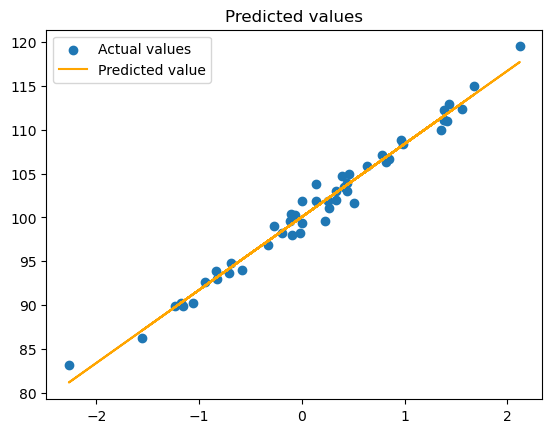

In [2]:
numerator = sum((x - x.mean()) * (y - y.mean()))
denominator = sum((x - x.mean())**2) 

w = numerator / denominator
b = y.mean() - w * x.mean()

print("Gradient:", w) 
print("bias:",b)
plt.scatter(x, y)
plt.title("Predicted values")
plt.plot(x,(w * x)+b, color='orange')
plt.legend(["Actual values", "Predicted value"])

# Accuracy of model

In [4]:
predictions = w*x +b
accuracy = r2_score(y, predictions)
print("R^2 score :", accuracy) 

R^2 score : 0.9808663599761945


# Transition to Cairo
## Create a scarb project

Scarb is the Cairo package manager specifically created to streamline our Cairo and Starknet development process. You can find all information about Scarb and Cairo installation here

In [5]:
! scarb new linear_regression

Created `linear_regression` package.


In [6]:
!echo -n > linear_regression/src/lib.cairo

A new project folder will be created for you and make sure to replace the content in Scarb.toml file with the following code:
```toml
[package]
name = "linear_regresion"
version = "0.1.0"


[dependencies]
orion = { git = "https://github.com/gizatechxyz/onnx-cairo" }

[scripts]
test = "scarb cairo-test -f linear_regression_test"
```

In [6]:
# add reference modules to help our code compile at the end
%%writefile linear_regression/src/lib.cairo
mod test;
mod data_preprocessing;
mod helper_functions;
mod datasets;
mod model;

SyntaxError: invalid syntax (3814475083.py, line 3)


## Generate Cairo files

Now, we will transition our model to cairo. We will start by converting the the x features and y labels to FP16x16 tensors numbers. 

In [7]:

def generate_cairo_files(data, name, folder_name):
    
    os.makedirs(f'linear_regression/src/datasets/{folder_name}', exist_ok=True)
    with open(os.path.join('linear_regression/src/datasets', f'{folder_name}', f"{name}.cairo"), "w") as f:
            f.write(
                "use array::ArrayTrait;\n" +
                "use orion::numbers::fixed_point::implementations::fp16x16::core::{FP16x16Impl, FP16x16PartialEq };\n" +
                "use orion::operators::tensor::{Tensor, TensorTrait, FP16x16Tensor};\n" +
                "use orion::numbers::{FP16x16, FixedTrait};\n\n" +
                "fn {0}() ->  Tensor<FP16x16>  ".format(name) + "{\n" +
                "    let tensor = TensorTrait::<FP16x16>::new( \n"
            )
            
            if len(data.shape)>1:
                f.write("    shape: array![{0},".format(data.shape[0]))
                f.write("{0}].span(),\n".format(data.shape[1]))
                f.write(
                    "    data: array![ \n"
                )
            if len(data.shape)==1:
                f.write("    shape: array![{0}].span(),\n".format(data.shape[0]))
                f.write(
                    "    data: array![ \n"
                )
            for val in np.nditer(data.flatten()):
                f.write("    FixedTrait::new({0}, {1} ),\n".format(abs(int(val * 2**16)), str(val < 0).lower()))
            f.write(
                "].span() \n \n" +
                ");\n\n"+
                "return tensor; \n"+
                "}"
            )
    with open(os.path.join('linear_regression/src/datasets', f'{folder_name}.cairo'), 'a') as f:
        f.write(f"mod {name};\n")

In [8]:
generate_cairo_files(x, 'x_feature_data', 'linear_data')
generate_cairo_files(y, 'y_label_data', 'linear_data')

In [9]:
# add reference modules to help our code compile
! touch linear_regression/src/datasets.cairo

In [10]:
%%writefile linear_regression/src/datasets.cairo
mod linear_data;

Overwriting linear_regression/src/datasets.cairo


In [11]:
! touch linear_regression/src/datasets/linear_data.cairo

In [12]:
%%writefile linear_regression/src/datasets/linear_data.cairo
mod x_feature_data;
mod y_label_data;

Overwriting linear_regression/src/datasets/linear_data.cairo


## Helper functions 

We add some helper functions that we may need during our linear regression model construction and testing

In [13]:
! touch linear_regression/src/helper_functions.cairo

In [14]:
%%writefile linear_regression/src/helper_functions.cairo


use debug::PrintTrait;
use array::{ArrayTrait, SpanTrait};
use orion::operators::tensor::{
    Tensor, TensorTrait, FP16x16Tensor, U32Tensor, U32TensorAdd, FP16x16TensorSub, FP16x16TensorAdd,
    FP16x16TensorDiv, FP16x16TensorMul
};

use orion::numbers::{FP16x16, FixedTrait};

// retrieves row data by index in a 2D tensor
fn get_tensor_data_by_row(tensor_data: Tensor<FP16x16>, row_index: u32,) -> Tensor<FP16x16> {
    let column_len = *tensor_data.shape.at(1); //13
    // crete new array
    let mut result = ArrayTrait::<FP16x16>::new();
    // loop through the x values and append values 
    let mut i: u32 = 0;
    loop {
        if i >= column_len {
            break ();
        }
        result.append(tensor_data.at(indices: array![row_index, i].span()));
        i += 1;
    };
    let resultant_tensor = TensorTrait::<
        FP16x16
    >::new(array![column_len].span(), data: result.span());
    return resultant_tensor;
}


// transposes tensor
fn transpose_tensor(tensor_data: Tensor<FP16x16>) -> Tensor<FP16x16> {
    let tensor_transposed = tensor_data.transpose(axes: array![1, 0].span());
    return tensor_transposed;
}

fn calculate_mean(tensor_data: Tensor<FP16x16>) -> FP16x16 {
    let tensor_size = FixedTrait::<FP16x16>::new_unscaled(tensor_data.data.len(), false);
    let cumulated_sum = tensor_data.cumsum(0, Option::None(()), Option::None(()));
    let sum_result = cumulated_sum.data[tensor_data.data.len() - 1];
    let mean = *sum_result / tensor_size;
    return mean;
}

// Calculates the R-Squared score between two tensors.
fn calculate_r_score(Y_values: Tensor<FP16x16>, Y_pred_values: Tensor<FP16x16>) -> FP16x16 {
    let mut Y_values_ = Y_values;
    let mean_y_value = calculate_mean(Y_values);
    // creating the appropriate tensor shapes and empty arrays to populate values into
    let mut squared_diff_shape = array::ArrayTrait::new();
    squared_diff_shape.append(Y_values.data.len());
    let mut squared_diff_vals = array::ArrayTrait::new();
    let mut squared_mean_diff_shape = array::ArrayTrait::new();
    squared_mean_diff_shape.append(Y_values.data.len());
    let mut squared_mean_diff_vals = array::ArrayTrait::new();

    let mut i: u32 = 0;

    loop {
        match Y_values_.data.pop_front() {
            Option::Some(y_value) => {
                let diff_pred = *y_value - *Y_pred_values.data.at(i);
                let squared_diff = diff_pred * diff_pred;
                squared_diff_vals.append(squared_diff);

                let diff_mean = *y_value - mean_y_value;
                let squared_mean_diff = diff_mean * diff_mean;
                squared_mean_diff_vals.append(squared_mean_diff);
                i += 1;
            },
            Option::None(_) => { break; }
        }
    };

    let squared_diff_tensor = TensorTrait::<
        FP16x16
    >::new(squared_diff_shape.span(), squared_diff_vals.span());
    let squared_mean_diff_tensor = TensorTrait::<
        FP16x16
    >::new(squared_mean_diff_shape.span(), squared_mean_diff_vals.span());
    let sum_squared_diff = squared_diff_tensor.cumsum(0, Option::None(()), Option::None(()));
    let sum_squared_mean_diff = squared_mean_diff_tensor
        .cumsum(0, Option::None(()), Option::None(()));
    let r_score = FixedTrait::new_unscaled(1, false)
        - *sum_squared_diff.data.at(Y_values.data.len() - 1)
            / *sum_squared_mean_diff.data.at(Y_values.data.len() - 1);

    return r_score;
}


// computes the x_min, x_max and x_range. Used for helping in normalizing and denormalizing user inputed values operations
fn normalize_user_x_inputs(
    x_inputs: Tensor<FP16x16>, original_x_values: Tensor<FP16x16>
) -> Tensor<FP16x16> {
    let mut x_inputs_normalized = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![FixedTrait::new(10, false)].span());

    let mut x_min = ArrayTrait::<FP16x16>::new();
    let mut x_max = ArrayTrait::<FP16x16>::new();
    let mut x_range = ArrayTrait::<FP16x16>::new();
    let mut result = ArrayTrait::<FP16x16>::new();

    if original_x_values.shape.len() > 1 {
        let transposed_tensor = original_x_values.transpose(axes: array![1, 0].span());
        let data_len = *transposed_tensor.shape.at(0); //13
        // loop through each row calculating the min, max and range row values for each feature columns
        let mut i: u32 = 0;
        loop {
            if i >= data_len {
                break ();
            }
            let mut transposed_tensor_row = get_tensor_data_by_row(transposed_tensor, i);
            x_min.append(transposed_tensor_row.min_in_tensor());
            x_max.append(transposed_tensor_row.max_in_tensor());
            x_range
                .append(
                    transposed_tensor_row.max_in_tensor() - transposed_tensor_row.min_in_tensor()
                );
            i += 1;
        };
        let mut x_min_tensor = TensorTrait::new(shape: array![data_len].span(), data: x_min.span());
        let mut x_max_tensor = TensorTrait::new(shape: array![data_len].span(), data: x_max.span());
        let mut x_range_tensor = TensorTrait::new(
            shape: array![data_len].span(), data: x_range.span()
        );

        // for normalizing 2D user inputed feature vals
        if x_inputs.shape.len() > 1 {
            let mut j: u32 = 0;
            loop {
                if j >= *x_inputs.shape.at(0) {
                    break ();
                };
                let mut row_data = get_tensor_data_by_row(x_inputs, j);
                let mut norm_row_data = (row_data - x_min_tensor) / x_range_tensor;
                let mut k: u32 = 0;

                loop {
                    if k >= norm_row_data.data.len() {
                        break ();
                    };
                    result.append(*norm_row_data.data.at(k));
                    k += 1;
                };
                j += 1;
            };
            x_inputs_normalized =
                TensorTrait::<
                    FP16x16
                >::new(
                    array![*x_inputs.shape.at(0), *x_inputs.shape.at(1)].span(), data: result.span()
                );
        };

        // for normalizing 1D feature input
        if x_inputs.shape.len() == 1 {
            x_inputs_normalized = (x_inputs - x_min_tensor) / x_range_tensor;
        };
    }

    if original_x_values.shape.len() == 1 {
        let mut x_min_tensor = TensorTrait::<
            FP16x16
        >::new(shape: array![1].span(), data: array![original_x_values.min_in_tensor()].span());
        let mut x_max_tensor = TensorTrait::<
            FP16x16
        >::new(shape: array![1].span(), data: array![original_x_values.max_in_tensor()].span());
        let mut x_range_tensor = TensorTrait::<
            FP16x16
        >::new(
            shape: array![1].span(),
            data: array![original_x_values.max_in_tensor() - original_x_values.min_in_tensor()]
                .span()
        );
        let mut diff = ((x_inputs - x_min_tensor));
        x_inputs_normalized = ((x_inputs - x_min_tensor)) / x_range_tensor;
    };
    return x_inputs_normalized;
}


// rescales model predictions to standard format
fn rescale_predictions(
    prediction_result: Tensor<FP16x16>, y_values: Tensor<FP16x16>
) -> Tensor<FP16x16> {
    let mut rescale_predictions = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![FixedTrait::new(10, false)].span());

    let mut y_min_array = ArrayTrait::<FP16x16>::new();
    let mut y_max_array = ArrayTrait::<FP16x16>::new();
    let mut y_range_array = ArrayTrait::<FP16x16>::new();

    let mut y_max = y_values.max_in_tensor();
    let mut y_min = y_values.min_in_tensor();
    let mut y_range = y_values.max_in_tensor() - y_values.min_in_tensor();
    // convert to tensor format for ease of math operations
    let y_min_tensor = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![y_min].span());
    let y_max_tensor = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![y_max].span());
    let y_range_tensor = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![y_range].span());

    rescale_predictions = (prediction_result * y_range_tensor) + y_min_tensor;

    return rescale_predictions;
}



Overwriting linear_regression/src/helper_functions.cairo


## Data-preprocessing functions

We can normalize our data but for this tutorial we will not as we are working with a relitively small and simple dataset. However, it is recommended to normalize data before passing it to the  linear regression model since we will be working with 16x16 fixed point numbers in cairo. This is to prevent  from having overflow issues as we compute the feature gradient values (some calculations involve squaring x values which can lead to relatively large if not normalized)

In [15]:
! touch linear_regression/src/data_preprocessing.cairo

In [16]:

%%writefile linear_regression/src/data_preprocessing.cairo


use orion::operators::tensor::{
    Tensor, TensorTrait, FP16x16Tensor, U32Tensor, U32TensorAdd, FP16x16TensorSub, FP16x16TensorAdd,
    FP16x16TensorDiv, FP16x16TensorMul
};
use orion::numbers::{FP16x16, FixedTrait};
use linear_regresion::helper_functions::{
    get_tensor_data_by_row, transpose_tensor, calculate_mean, calculate_r_score,
    normalize_user_x_inputs, rescale_predictions
};

#[derive(Copy, Drop)]
struct Dataset {
    x_values: Tensor<FP16x16>,
    y_values: Tensor<FP16x16>,
}

#[generate_trait]
impl DataPreprocessing of DatasetTrait {
    fn normalize_dataset(ref self: Dataset) -> Dataset {
        let mut x_values = TensorTrait::<FP16x16>::new(array![1].span(), array![FixedTrait::new(0, false)].span());
        let mut y_values = TensorTrait::<FP16x16>::new(array![1].span(), array![FixedTrait::new(0, false)].span());
        // used for multiple_linear_regression_models
        if self.x_values.shape.len() > 1 {
            x_values = normalize_feature_data(self.x_values);
            y_values = normalize_label_data(self.y_values);
        }
        // used for linear_regression_models
        if self.x_values.shape.len() == 1 {
            x_values = normalize_label_data(self.x_values);
            y_values = normalize_label_data(self.y_values);
        }

        return Dataset { x_values, y_values };
    }
}

// normalizes 2D Tensor
fn normalize_feature_data(tensor_data: Tensor<FP16x16>) -> Tensor<FP16x16> {
    let mut x_min_array = ArrayTrait::<FP16x16>::new();
    let mut x_max_array = ArrayTrait::<FP16x16>::new();
    let mut x_range_array = ArrayTrait::<FP16x16>::new();
    let mut normalized_array = ArrayTrait::<FP16x16>::new();
    // transpose to change rows to be columns
    let transposed_tensor = tensor_data.transpose(axes: array![1, 0].span());
    let tensor_shape = transposed_tensor.shape;
    let tensor_row_len = *tensor_shape.at(0); // 13 
    let tensor_column_len = *tensor_shape.at(1); //50
    // loop and append max and min row values to corresponding  array
    let mut i: u32 = 0;
    loop {
        if i >= tensor_row_len {
            break ();
        }
        let mut transposed_tensor_row = get_tensor_data_by_row(transposed_tensor, i);
        x_max_array.append(transposed_tensor_row.max_in_tensor());
        x_min_array.append(transposed_tensor_row.min_in_tensor());
        x_range_array
            .append(transposed_tensor_row.max_in_tensor() - transposed_tensor_row.min_in_tensor());
        i += 1;
    };
    // convert array to tensor format for ease of math operation
    let mut x_min = TensorTrait::<
        FP16x16
    >::new(shape: array![1, tensor_row_len].span(), data: x_min_array.span());
    let mut x_range = TensorTrait::<
        FP16x16
    >::new(shape: array![1, tensor_row_len].span(), data: x_range_array.span());
    let normalized_tensor = (tensor_data - x_min) / x_range;
    return normalized_tensor;
}

// normalizes 1D tensor
fn normalize_label_data(tensor_data: Tensor<FP16x16>) -> Tensor<FP16x16> {
    let mut tensor_data_ = tensor_data;
    let mut normalized_array = ArrayTrait::<FP16x16>::new();
    let mut range = tensor_data.max_in_tensor() - tensor_data.min_in_tensor();
    // loop through tensor values normalizing and appending to new array
    let mut i: u32 = 0;

    loop {
        match tensor_data_.data.pop_front() {
            Option::Some(tensor_val) => {
                let mut diff = *tensor_val - tensor_data.min_in_tensor();
                normalized_array.append(diff / range);
                i += 1;
            },
            Option::None(_) => { break; }
        };
    };
    // convert normalized array values to tensor format
    let mut normalized_tensor = TensorTrait::<
        FP16x16
    >::new(shape: array![tensor_data.data.len()].span(), data: normalized_array.span());
    return normalized_tensor;
}




Overwriting linear_regression/src/data_preprocessing.cairo


## Linear Regression Model

Implement the Linear Regression functions

In [17]:
os.makedirs(f'linear_regression/src/model/', exist_ok=True)

In [18]:
! touch linear_regression/src/model/linear_regression_model.cairo

In [19]:
%%writefile linear_regression/src/model/linear_regression_model.cairo

use orion::operators::tensor::{
    Tensor, TensorTrait, FP16x16Tensor, U32Tensor, U32TensorAdd, FP16x16TensorSub, FP16x16TensorAdd,
    FP16x16TensorDiv, FP16x16TensorMul
};
use orion::numbers::{FP16x16, FixedTrait};
use linear_regresion::data_preprocessing::{Dataset, DatasetTrait};
use linear_regresion::helper_functions::{
    get_tensor_data_by_row, transpose_tensor, calculate_mean, calculate_r_score,
    normalize_user_x_inputs, rescale_predictions
};

#[derive(Copy, Drop)]
struct LinearRegressionModel {
    gradient: Tensor<FP16x16>,
    bias: Tensor<FP16x16>
}

#[generate_trait]
impl RegressionOperation of LinearRegressionModelTrait {
    fn predict(ref self: LinearRegressionModel, x_input: Tensor<FP16x16>) -> Tensor<FP16x16> {
        let gradient = self.gradient;
        let bias = self.bias;
        let mut prediction = (gradient * x_input) + bias;
        return prediction;
    }
}

fn LinearRegression(dataset: Dataset) -> LinearRegressionModel {
    let gradient = compute_gradient(dataset);
    let bias = compute_bias(dataset);
    return LinearRegressionModel { gradient, bias };
}

// computes the mean of a given 1D tensor and outputs result as tensor
fn compute_mean(tensor_data: Tensor<FP16x16>) -> Tensor<FP16x16> {
    let tensor_size = FixedTrait::<FP16x16>::new_unscaled(tensor_data.data.len(), false);
    let cumulated_sum = tensor_data.cumsum(0, Option::None(()), Option::None(()));
    let sum_result = cumulated_sum.data[tensor_data.data.len() - 1];
    let mean = *sum_result / tensor_size;
    let mut result_tensor = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![mean].span());
    return result_tensor;
}


/// Calculates the deviation of each element from the mean of the provided 1D tensor.
fn deviation_from_mean(tensor_data: Tensor<FP16x16>) -> Tensor<FP16x16> {
    let mut tensor_data_ = tensor_data;
    let mean_value = calculate_mean(tensor_data);
    let mut tensor_shape = array::ArrayTrait::new();
    tensor_shape.append(tensor_data.data.len());
    let mut deviation_values = array::ArrayTrait::new();

    let mut i: u32 = 0;

    loop {
        match tensor_data_.data.pop_front() {
            Option::Some(tensor_val) => {
                let distance_from_mean = *tensor_val - mean_value;
                deviation_values.append(distance_from_mean);
                i += 1;
            },
            Option::None(_) => { break; }
        };
    };
    let distance_from_mean_tensor = TensorTrait::<
        FP16x16
    >::new(tensor_shape.span(), deviation_values.span());

    return distance_from_mean_tensor;
}

/// Calculates the beta value for linear regression.
fn compute_gradient(dataset: Dataset) -> Tensor<FP16x16> {
    let x_deviation = deviation_from_mean(dataset.x_values);
    let y_deviation = deviation_from_mean(dataset.y_values);

    let x_y_covariance = x_deviation.matmul(@y_deviation);
    let x_variance = x_deviation.matmul(@x_deviation);

    let beta_value = x_y_covariance / x_variance;

    return beta_value;
}


/// Calculates the intercept for linear regression.
fn compute_bias(dataset: Dataset) -> Tensor<FP16x16> {
    let x_mean = compute_mean(dataset.x_values);
    let y_mean = compute_mean(dataset.y_values);
    let gradient = compute_gradient(dataset);
    let mx = gradient * x_mean;
    let intercept = y_mean - mx;
    return intercept;
}



Overwriting linear_regression/src/model/linear_regression_model.cairo


In [20]:
! touch linear_regression/src/model.cairo

In [21]:
%%writefile linear_regression/src/model.cairo
mod linear_regression_model;

Overwriting linear_regression/src/model.cairo


## Running tests on model

Running some checks to ensure the model is performing as expected. Some of the checks involve:
- tensor shape/dimension check
- gradient and bias value and dimension checks  
- model accuracy deviance checks

In [22]:
! touch linear_regression/src/test.cairo

In [23]:
%%writefile linear_regression/src/test.cairo
// use traits::Into;
use debug::PrintTrait;
use array::{ArrayTrait, SpanTrait};


use linear_regresion::datasets::linear_data::x_feature_data::x_feature_data;
use linear_regresion::datasets::linear_data::y_label_data::y_label_data;


use orion::numbers::{FP16x16,  FixedTrait};
use linear_regresion::model::linear_regression_model::{
     LinearRegressionModel, compute_mean, LinearRegression, LinearRegressionModelTrait
};

use linear_regresion::data_preprocessing::{Dataset, DatasetTrait};
use linear_regresion::helper_functions::{get_tensor_data_by_row, transpose_tensor, calculate_mean , 
calculate_r_score, normalize_user_x_inputs, rescale_predictions};

use orion::operators::tensor::{
    Tensor, TensorTrait, FP16x16Tensor, U32Tensor, U32TensorAdd, 
    FP16x16TensorSub, FP16x16TensorAdd, FP16x16TensorDiv, FP16x16TensorMul};

#[test]
#[available_gas(99999999999999999)]
fn multiple_linear_regression_test() {


// // ----------------------------------------------------------------Simple Linear regression tests---------------------------------------------------------------------------------

let mut main_x_vals = x_feature_data();
let mut main_y_vals = y_label_data();
let dataset = Dataset{x_values: main_x_vals,y_values:main_y_vals};
let mut model = LinearRegression(dataset);
let gradient = model.gradient;
let mut reconstructed_ys = model.predict(main_x_vals);
let mut r_squared_score = calculate_r_score(main_y_vals,reconstructed_ys);
r_squared_score.print(); 

// performing checks on shape on coefficient values (gradient vals + bias) 
assert(model.gradient.data.len() == 1,  'gradient data shape mismatch');
assert(model.bias.data.len() == 1,  'bias data shape mismatch');
// model accuracy deviance checks
assert(r_squared_score >= FixedTrait::new(62259, false), 'Linear model acc. less than 95%');


// linear regression model new input predictions
let mut user_value =   TensorTrait::<FP16x16>::new(shape: array![2].span(), data: array![FixedTrait::new(65536, false), FixedTrait::new(65536, true)].span());
let mut prediction_results = model.predict(user_value);
(*prediction_results.data.at(0)).print(); 
(*prediction_results.data.at(1)).print();


}



Overwriting linear_regression/src/test.cairo
